# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file.

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [ ]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
def get_data():
  return pd.read_csv('/content/insurance.csv')

file_size = os.path.getsize('/content/insurance.csv') / (10 ^ 6)
print("File Size is :", file_size, "MB")
print()

data = get_data()
data.shape
print("Entries:", data.shape[0])
print("Features:", data.shape[1])
print()

categorical_data = data.select_dtypes(include=['object'])
print("Categorical Features:", categorical_data.shape[1])
print()

print("Missing values:")
print(data.isnull().sum())
print()

print("Statistical Overview:")
print(data.describe())

File Size is : 4635.666666666667 MB

Entries: 1338
Features: 7

Categorical Features: 3

Missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Statistical Overview:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class.

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadad80d950>,
      dtype=object)

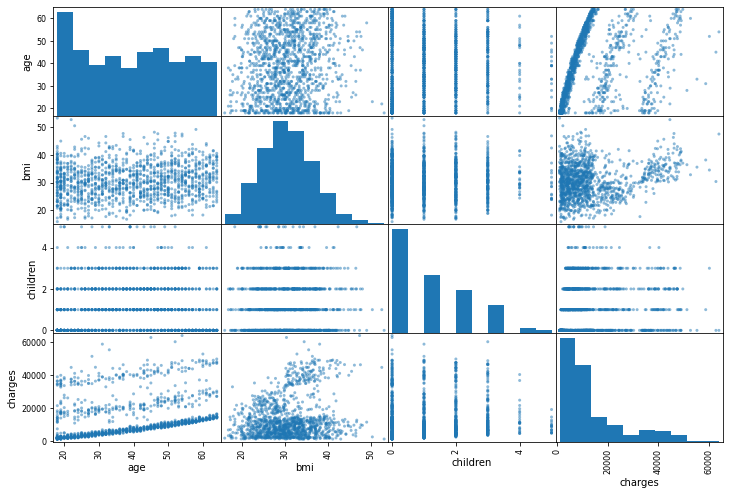

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["age", "bmi", "children","charges"]
scatter_matrix(data[attributes], figsize=(12, 8))

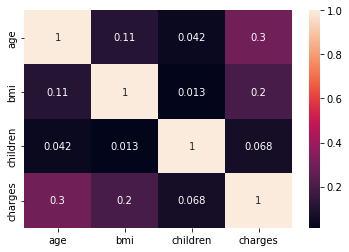

In [ ]:

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sn

corr_matrix = data.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, input_array, y=None):
        return self

    def transform(self, input_array, y=None):
        return input_array*1

# Split the data into train set (80%) and test set (20%)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=17)

df_numerical = data.select_dtypes(include=[np.number]).copy()
df_categorical = data.select_dtypes(include=['object']).copy()

num_pipeline = Pipeline([
    ('NormalizeData', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('encode', OneHotEncoder(handle_unknown='ignore')),
    ('std_scaler', StandardScaler(with_mean=False)),
])

num_pipeline_unscaled = Pipeline([ #how to make a 'passthough' pipeline?
    ('pass_through', IdentityTransformer()),
])

cat_pipeline_unscaled = Pipeline([
    ('encode', OneHotEncoder(handle_unknown='ignore')),
])


num_attribs = list(df_numerical.drop('charges', axis=1))
cat_attribs = list(df_categorical)

scaling_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

non_scaling_pipeline = ColumnTransformer([
    ("num", num_pipeline_unscaled, num_attribs),
    ("cat", cat_pipeline_unscaled, cat_attribs)
])

# For gradient decent
X_train = scaling_pipeline.fit_transform(train_set)
y_train = np.asmatrix(train_set["charges"].tolist()).T
X_test = scaling_pipeline.fit_transform(test_set)
y_test = np.asmatrix(test_set["charges"].tolist()).T
# For library Gradient Decent
train_labels = train_set["charges"].tolist()
test_labels = test_set["charges"].tolist()

# For normal equation
X_train_unscaled = non_scaling_pipeline.fit_transform(train_set)
X_test_unscaled = non_scaling_pipeline.fit_transform(test_set)
print(X_train_unscaled[:5])
print(X_train[:5])

[[61.   35.91  0.    1.    0.    1.    0.    1.    0.    0.    0.  ]
 [61.   35.86  0.    0.    1.    0.    1.    0.    0.    1.    0.  ]
 [21.   39.49  0.    1.    0.    1.    0.    0.    0.    1.    0.  ]
 [20.   31.92  0.    1.    0.    1.    0.    0.    1.    0.    0.  ]
 [32.   37.18  2.    0.    1.    1.    0.    0.    0.    1.    0.  ]]
[[ 1.57228078  0.84838788 -0.93092365  2.00003144  0.          2.46200903
   0.          2.3166632   0.          0.          0.        ]
 [ 1.57228078  0.84021775 -0.93092365  0.          2.00003144  0.
   2.46200903  0.          0.          2.25221237  0.        ]
 [-1.31066059  1.43336923 -0.93092365  2.00003144  0.          2.46200903
   0.          0.          0.          2.25221237  0.        ]
 [-1.38273412  0.19641147 -0.93092365  2.00003144  0.          2.46200903
   0.          0.          2.30510854  0.          0.        ]
 [-0.51785171  1.0559092   0.73896454  0.          2.00003144  2.46200903
   0.          0.          0.          2

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods.

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [ ]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = []; # parameter vector;
    self.alpha = []; # learning rate
    self.cost  = []; # cost function

    self.theta_best = None

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT:
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    for _ in range(iters):
      gradients = 2/X_train.shape[0] * X_train.T.dot(X_train.dot(theta) - y_train)

      # compute MSE
      diff = np.subtract(np.dot(X_train, theta), y_train)
      square_error = np.power(diff, 2)
      sum_square_error = np.sum(square_error)
      mse = sum_square_error / X_train.shape[0]

      # update values for next itteration
      self.theta.append(theta)
      self.alpha.append(alpha)
      self.cost.append(mse)

      theta = theta - alpha * gradients

    return self.theta[-1], self.cost[-1]

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here

    #add all 1s cloumn for x_0
    x_0_column = np.ones(X_train.shape[0])
    adj_X_train = np.insert(X_train, 0, x_0_column, axis=1)

    # hyper parameters - abitrary choices
    learning_rate = 0.1
    num_itters = 10
    num_repititions = 1

    min_cost = None
    best_theta = None
    for _ in range(num_repititions):
      theta_guess = np.random.rand(adj_X_train.shape[1],1)
      self.gradientDescent(adj_X_train, y_train, theta_guess, learning_rate, num_itters)
      if min_cost is None or self.cost[-1] < min_cost:
        min_cost = self.cost[-1]
        best_theta = self.theta[-1]
        self.theta_best = best_theta

    return best_theta, min_cost

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """

    X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
    self.theta_best = theta_best

    differenceSquared = np.power(X_b.dot(theta_best) - y_train, 2)
    sumErrorSq = np.sum(differenceSquared)
    mse = sumErrorSq/X_b.shape[0]

    self.cost.append(mse)
    self.theta.append(theta_best)

    return theta_best, mse



  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here
    x_0_column = np.ones(X_test.shape[0])
    X_test = np.insert(X_test, 0, x_0_column, axis=1)
    if self.theta_best is None:
      return None
    return np.dot(X_test, self.theta_best)

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }
    return f"Parameter vector is {self.theta_best}"

# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
theta, cost = myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
print(f"MSE: {cost} or RSME: {cost ** 0.5} \ntheta:  {theta}")


MSE: 39288133.348766714 or RSME: 6268.024676783485 
theta:  [[ 2855.62744649]
 [ 2995.52284324]
 [ 1802.41360672]
 [  496.3244393 ]
 [ 2868.69347442]
 [ 2842.21413358]
 [-1199.61108444]
 [ 8230.19377483]
 [ 1812.61663927]
 [ 1630.22606987]
 [ 1711.32873626]
 [ 1439.93123584]]


* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


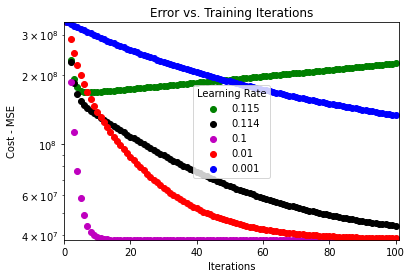

In [ ]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
import matplotlib.pyplot as plt

fig = plt.figure()
plt.xlabel('Iterations')
plt.ylabel('Cost - MSE')
plt.title('Error vs. Training Iterations')
ax1 = fig.add_subplot()

learning_rates = [0.115, 0.114, 0.1, 0.01, 0.001] #max is 5! (because of colors array)
colors = ['b', 'r', 'm', 'k', 'g']
num_itterations = 100
data = [] # type list(tuple(alpha, cost_list()))

ax1.set_xlim([0, num_itterations+1])
largest = 0
smallest = 10 ** 20 # abitrary large number

#add all 1s cloumn for x_0
x_0_column = np.ones(X_train.shape[0])
adj_X_train = np.insert(X_train, 0, x_0_column, axis=1)
theta_guess = np.random.rand(adj_X_train.shape[1],1)
for alpha in learning_rates:
  myDGM = MyLinearRegression()
  myDGM.gradientDescent(adj_X_train, y_train, theta_guess, alpha, num_itterations)
  data.append((alpha, myDGM.cost))
  smallest = min(smallest, min(myDGM.cost))
  largest = max(largest, max(myDGM.cost))

ax1.set_ylim([smallest, largest])
plt.yscale("log")

x_data = list(range(1, num_itterations+1))
for datum in data:
  ax1.scatter(x_data, datum[1], c=colors.pop(), marker="o", label=str(datum[0]))

plt.legend(loc='best', title = "Learning Rate")
plt.show()

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement:

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [ ]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
#? How to do this on unscaled data? New pipeline?
myNormalEquationModel = MyLinearRegression()
theta, cost = myNormalEquationModel.fitUsingNormalEquation(X_train_unscaled, y_train) # unscaled data
print(f"MSE: {cost} or RSME: {cost ** 0.5} \ntheta:  {theta}")

MSE: 5810227731.125573 or RSME: 76224.84982684828 
theta:  [[-2.16809150e+19]
 [ 8.56978375e+02]
 [ 5.54273719e+03]
 [ 2.22641853e+03]
 [ 2.03093224e+19]
 [ 2.03093224e+19]
 [ 1.37159259e+18]
 [ 1.37159259e+18]
 [-6.92842573e+03]
 [-1.33654970e+04]
 [ 1.16624456e+03]
 [ 6.00469818e+03]]


- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [ ]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train, train_labels)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(test_labels, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("Library SGD (Comparison) RMSE:", mySGDModel_rmse)

y_predict = myGradientDescentModel.predict(X_test)
mse = mean_squared_error(test_labels, y_predict)
myGradientDescentModel_rmse = np.sqrt(mse)
print("My Graident Decent Implimentation RMSE:", myGradientDescentModel_rmse)

y_predict = myNormalEquationModel.predict(X_test_unscaled)
mse = mean_squared_error(test_labels, y_predict)
myNormalEquationModel_rmse = np.sqrt(mse)
print("My Normal Equation Implimentation RMSE:", myNormalEquationModel_rmse)
print("I have no idea why my normal equation RMSE is so high. I followed the code from the slides exactly for that part")



Library SGD (Comparison) RMSE: 5650.602538584423
My Graident Decent Implimentation RMSE: 5804.309530058381
My Normal Equation Implimentation RMSE: 77022.38354143071
I have no idea why my normal equation RMSE is so high. I followed the code from the slides exactly for that part


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


- - -
## Task 6. PRESENT YOUR SOLUTION

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following:

* How can you pitch your solution to this project?
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

  In this notebook I have preformed a learning exercise to better understand the under the hood implimentation of common Machine Learning Algorithms. Often I can take for advantage the abstractions that common Machine Learning tools like scikit-learn, but this exerice forced me to think more cirtically about manipulating data to extract trends. I learned for this case study that age and bmi are the strongly corrilated with medical expernces. This was largely supported by the machine learning model but being a smoker was also a good predictor of medical expeneces. Finally I would like to signal that the the machine learning model indicated that there was high bias in the data. This means that there are likely better features that would predict medical expenses. I would recommend we allocate resources to getting a data set with more features to intteralize this bias and gain sharper insight to this problem.

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!